In [86]:
import torch
import os
import cv2
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [87]:
import numpy as np 
import torchinfo
from torchinfo import summary

In [88]:
filename=os.listdir("./cnn_data/training_data/dhoni_train")
filename[0]

'dhoni_10.jpg'

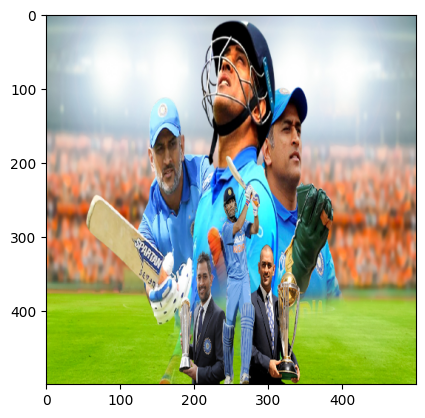

In [89]:
image=cv2.imread("./cnn_data/training_data/dhoni_train/dhoni_7.jpg")
image=cv2.resize(image,dsize=(500,500))
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

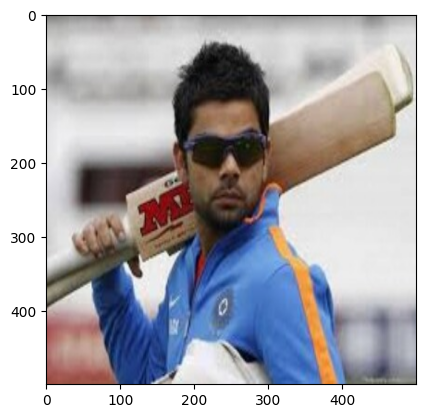

In [90]:
image=cv2.imread("./cnn_data/training_data/kholi_train/kholi_5.jpg")
image=cv2.resize(image,dsize=(500,500))
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [91]:
import glob as glob
from concurrent.futures import ThreadPoolExecutor,as_completed

def process_image(filename):
    image=cv2.imread(filename)
    try:
        if image is not None:
            image=cv2.resize(image,dsize=(500,500))
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            return image 
        else :
            print(f"failed to read image")
            return None
        
    except cv2.Error as e:
        print(f"Cv2 error occured {e}")
        return None
        
    except Exception as e:
        print(f"Exception occured due to {e}")
        return None
 
        
def load_image(path):
    images=[]
    file_pattern=os.path.join(path,"*jpg")
    filename=glob.glob(file_pattern)
    
    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_filename = {executor.submit(process_image, filename): filename for filename in filename[0: int(1*len(filename))]}
        for future in tqdm(as_completed(future_to_filename), total=len(filename)):
            result = future.result()
            if result is not None:
                images.append(result)            
    return np.array(images)

In [92]:
iamge=load_image("./cnn_data/training_data/dhoni_train")
iamge

100%|██████████| 7/7 [00:00<00:00, 133.83it/s]

array([[[[ 94, 175, 202],
         [ 93, 173, 203],
         [ 91, 171, 204],
         ...,
         [ 20,  32,  46],
         [ 20,  32,  46],
         [ 20,  32,  46]],

        [[ 94, 175, 202],
         [ 93, 173, 203],
         [ 91, 171, 204],
         ...,
         [ 20,  32,  46],
         [ 20,  32,  46],
         [ 20,  32,  46]],

        [[ 92, 174, 203],
         [ 92, 173, 204],
         [ 91, 171, 205],
         ...,
         [ 20,  32,  46],
         [ 20,  32,  46],
         [ 20,  32,  46]],

        ...,

        [[  4,  26, 123],
         [  4,  26, 123],
         [  3,  26, 123],
         ...,
         [ 44,  61,  73],
         [ 44,  61,  73],
         [ 44,  61,  73]],

        [[  2,  26, 122],
         [  2,  26, 122],
         [  2,  26, 122],
         ...,
         [ 44,  62,  74],
         [ 44,  62,  74],
         [ 44,  62,  74]],

        [[  2,  26, 122],
         [  2,  26, 122],
         [  2,  26, 122],
         ...,
         [ 44,  62,  74],
        

In [93]:
dhoni_train=load_image("./cnn_data/training_data/dhoni_train")
dhoni_test=load_image("./cnn_data/testing_data/dhoni_test")
kholi_train=load_image("./cnn_data/training_data/kholi_train")
kholi_test=load_image("./cnn_data/testing_data/kholi_test")

100%|██████████| 3/3 [00:00<00:00, 36.23it/s]


In [94]:
dhoni_train.shape,dhoni_test.shape,kholi_train.shape,kholi_test.shape

((7, 500, 500, 3), (3, 500, 500, 3), (7, 500, 500, 3), (3, 500, 500, 3))

In [95]:
np.save("dhoni_train.npy",dhoni_train)
np.save("dhoni_test.npy",dhoni_test)
np.save("kholi_train.npy",kholi_train)
np.save("kholi_test.npy",kholi_test)

In [96]:
test=np.load("dhoni_test.npy")
test.shape

(3, 500, 500, 3)

In [97]:
df=np.append(dhoni_train,kholi_train,axis=0)
df.shape

(14, 500, 500, 3)

In [98]:
x_train=np.append(dhoni_train,kholi_train,axis=0)
x_test=np.append(dhoni_test,kholi_test,axis=0)

In [99]:
a=[0]*5
type(a),a

(list, [0, 0, 0, 0, 0])

In [100]:
len(dhoni_train),len(dhoni_test)

(7, 3)

In [101]:
y_train=np.array([0]*len(dhoni_train)+[1]*len(kholi_train)).reshape(-1,1)
y_test=np.array([0]*len(dhoni_test)+[0]*len(kholi_test)).reshape(-1,1)
y_train.shape,y_test.shape

((14, 1), (6, 1))

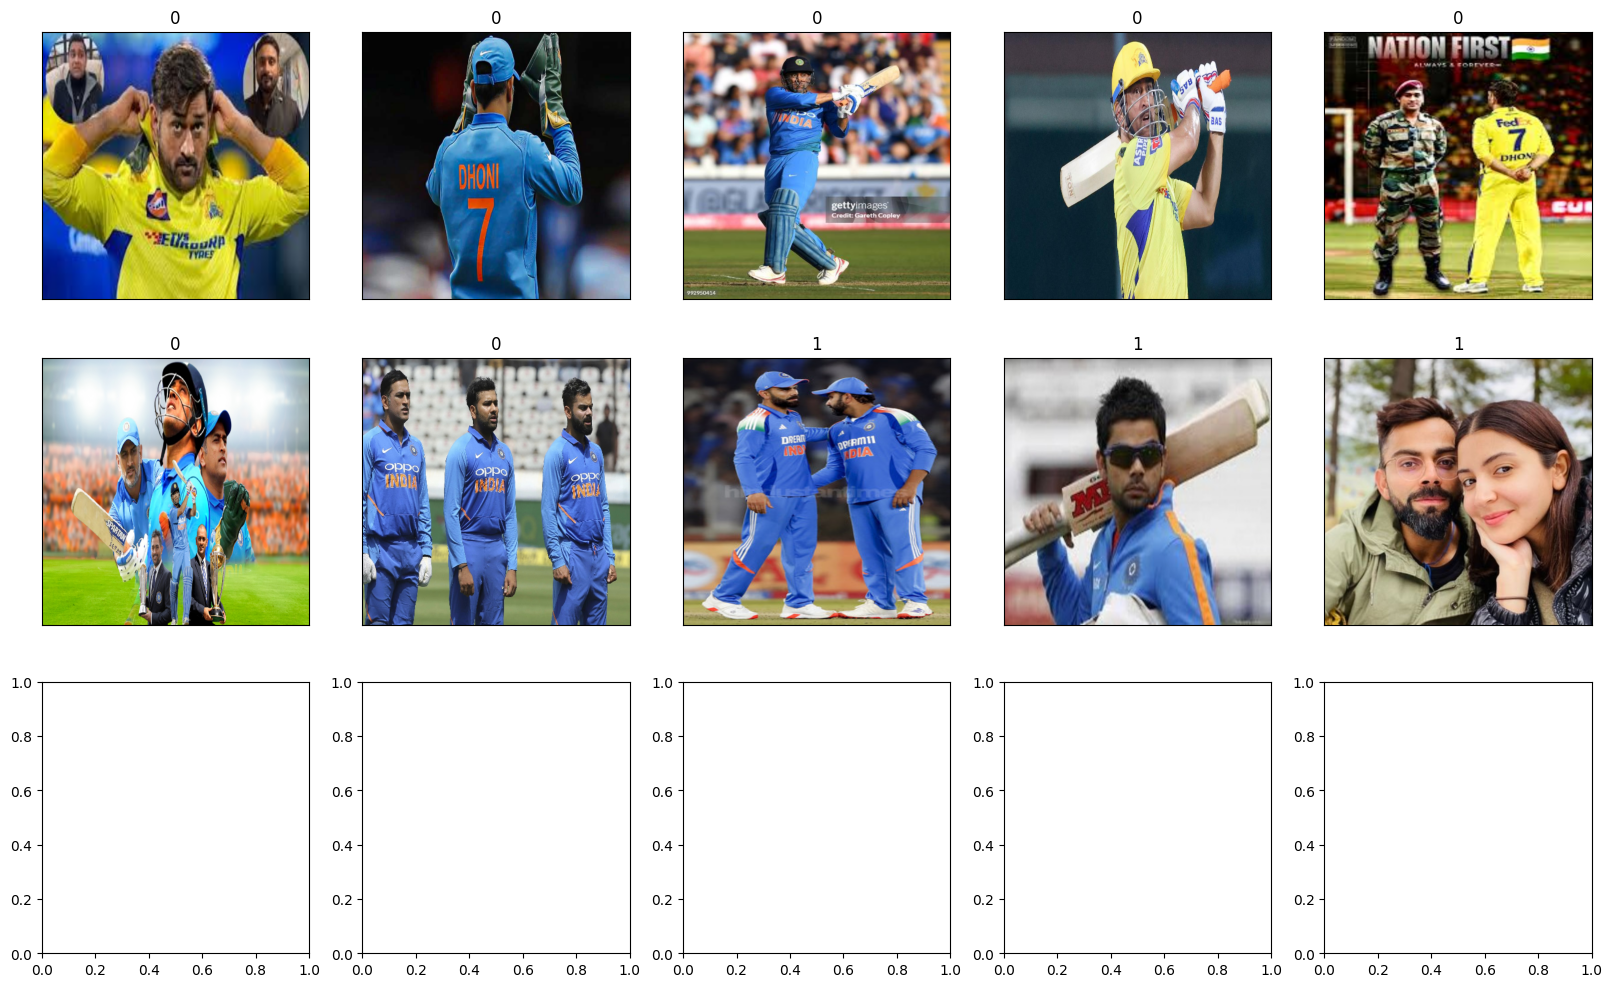

In [102]:
def show_image(image,label,start_index):
    fiq,axs=plt.subplots(nrows=3,ncols=5,figsize=(20,12))
    
    start_index=0
    for i in range(2):
        for j in range(5):
            axs[i][j].imshow(image[start_index])
            axs[i][j].set_title(label[start_index].item())
            axs[i][j].get_xaxis().set_visible(False)
            axs[i][j].get_yaxis().set_visible(False)
            start_index+=1

show_image(x_train,y_train,0)

In [103]:
train_datatransforms=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.05),
        transforms.RandomRotation(20),
        transforms.RandomGrayscale(p=0.2),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ]
)

In [104]:
test_datatransforms=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
    ]
)

In [105]:
# x_train=torch.tensor(x_train)
# x_train.dtype

In [106]:
x_train.shape

(14, 500, 500, 3)

In [107]:
x_test.shape

(6, 500, 500, 3)

In [108]:
class Data(Dataset):
    def __init__(self,images,labels,transform=None):
        super().__init__()
        self.images=images
        self.labels=labels
        self.transform=transform
        
    def __getitem__(self,index):
        image=self.images[index]
        label=self.labels[index]
        if self.transform:
            image=self.transform(image)
        return (image,label)
    
    def __len__(self):
        return len(self.images)     

In [109]:
train_data=Data(x_train,y_train,train_datatransforms)
train_data[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 array([0]))

In [110]:
len(Data(x_train,y_train,train_datatransforms))


14

In [111]:
test_data=Data(x_test,y_test,test_datatransforms)
len(test_data)

6

In [112]:
train_dataloader=DataLoader(
    dataset=train_data,
    shuffle=True,
    batch_size=2,
    drop_last=False,
)
for i in train_dataloader:
    print(i)

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1

In [113]:
test_dataloader=DataLoader(
    dataset=test_data,
    shuffle=True,
    batch_size=2,
    drop_last=True,
)
for i in test_dataloader:
    print(i)

[tensor([[[[ 0.9922,  0.9843,  0.9843,  ...,  0.8039,  0.7647,  0.7490],
          [ 0.9922,  0.9922,  0.9843,  ...,  0.8118,  0.7725,  0.7647],
          [ 0.9922,  0.9922,  0.9843,  ...,  0.8431,  0.8039,  0.7961],
          ...,
          [ 0.9686,  0.9686,  0.9765,  ...,  0.9059,  0.9216,  0.9294],
          [ 0.9529,  0.9608,  0.9765,  ...,  0.9059,  0.9059,  0.9137],
          [ 0.9529,  0.9608,  0.9765,  ...,  0.8980,  0.9059,  0.9059]],

         [[ 1.0000,  1.0000,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.9843,  0.9843,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9765,  0.9765,  0.9843,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9686,  0.9686,  0.9843,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  0.8667,  0.8902,  0.8980],
          [ 1.0000,  1.0000, 

In [114]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0=nn.Conv2d(
            in_channels=3,
            out_channels=32,
            stride=1,
            padding=1,
            kernel_size=3,
        )
        self.bn0=nn.BatchNorm2d(num_features=32)
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv1=nn.Conv2d(
            in_channels=32,
            out_channels=64,
            stride=1,
            padding=(1,1),
            kernel_size=(3,3),
        )
        self.bn1=nn.BatchNorm2d(num_features=64)
        
        self.conv2=nn.Conv2d(
            in_channels=64,
            out_channels=128,
            stride=1,
            padding=1,
            kernel_size=3,
        )
        self.bn2=nn.BatchNorm2d(num_features=128)
        
        self.fc0=nn.Linear(
            in_features=128*62*62,
            out_features=64,
        )
        
        self.fc1=nn.Linear(
            in_features=64,
            out_features=32,
        )
        
        self.fc2=nn.Linear(
            in_features=32,
            out_features=1,
        )
        
    def forward(self,x):
        x=nn.functional.relu(self.bn0(self.conv0(x)))
        x=self.maxpool(x)
        
        x=nn.functional.relu(self.bn1(self.conv1(x)))
        x=self.maxpool(x)
        
        x=nn.functional.relu(self.bn2(self.conv2(x)))
        x=self.maxpool(x)
        
        x=x.reshape(x.shape[0],-1)
        
        x=nn.functional.relu(self.fc0(x))
        
        x=nn.functional.relu(self.fc1(x))
        
        x=nn.functional.sigmoid(self.fc2(x))
        
        return x
        
        

In [115]:
model=CNN()
print(model)

CNN(
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=492032, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [116]:
random_input=torch.randn(16,3,500,500)
pred=model(random_input)
pred,pred.dtype

(tensor([[0.5191],
         [0.5044],
         [0.5002],
         [0.5084],
         [0.5135],
         [0.5437],
         [0.4927],
         [0.5094],
         [0.4897],
         [0.4985],
         [0.5135],
         [0.4918],
         [0.4944],
         [0.4931],
         [0.5074],
         [0.5038]], grad_fn=<SigmoidBackward0>),
 torch.float32)

In [117]:
summary(model,input_size=(16,3,500,500))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [16, 1]                   --
├─Conv2d: 1-1                            [16, 32, 500, 500]        896
├─BatchNorm2d: 1-2                       [16, 32, 500, 500]        64
├─MaxPool2d: 1-3                         [16, 32, 250, 250]        --
├─Conv2d: 1-4                            [16, 64, 250, 250]        18,496
├─BatchNorm2d: 1-5                       [16, 64, 250, 250]        128
├─MaxPool2d: 1-6                         [16, 64, 125, 125]        --
├─Conv2d: 1-7                            [16, 128, 125, 125]       73,856
├─BatchNorm2d: 1-8                       [16, 128, 125, 125]       256
├─MaxPool2d: 1-9                         [16, 128, 62, 62]         --
├─Linear: 1-10                           [16, 64]                  31,490,112
├─Linear: 1-11                           [16, 32]                  2,080
├─Linear: 1-12                           [16, 1]               

In [118]:
from torch import optim
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.BCELoss()

In [119]:
device=torch.device("cpu")

In [120]:
def predict():
    total=0
    correct=0
    with torch.inference_mode():
        for batch,(x,y) in enumerate(test_dataloader):
            x=x.float().to(device)
            y=y.float().to(device)
            pred=model(x)
            test_loss=loss_fn(pred,y)
            rounded_pred=np.round(pred)
            correct+=torch.sum(rounded_pred==y)
            total+=len(y)
        test_acc=correct/total
            
        return test_acc,test_loss

In [121]:

train_losses=[]
test_losses=[]
train_accs=[]
test_accs=[]
total,correct=0,0
for epoch in range(30):
    model.to(device)
    model.train()
    for batch,(x,y) in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        x=x.float().to(device)
        y=y.float().to(device)
        optimizer.zero_grad()
        pred=model(x)
        loss=loss_fn(pred,y)
        pred_rounded=torch.round(pred)
        correct+=torch.sum(pred_rounded==y)
        total+=len(y)
        loss.backward()
        optimizer.step()
    train_accuracy=correct/total
    test_acc,test_loss=predict()
    #.item() converst torch tensor to a scalar int or float values
    train_losses.append(loss.item())
    train_accs.append(train_accuracy.item())
    test_losses.append(test_loss.item())
    test_accs.append(test_acc.item())
    
    
    print(
        f"Epoch: {epoch} \t|"
        f" Train loss: {np.round(loss.item(),4)} \t|"
        f" Test loss: {np.round(test_loss.item(),4)} \t|"
        f" Train acc: {np.round(train_accuracy.item(),4)} \t|"
        f" Test acc: {np.round(test_acc.item(),4)}"
    )
    
        

100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


Epoch: 0 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:28<00:00,  4.08s/it]


Epoch: 1 	| Train loss: 0.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Epoch: 2 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Epoch: 3 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch: 4 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 5 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch: 6 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch: 7 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 8 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 9 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Epoch: 10 	| Train loss: 0.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


Epoch: 11 	| Train loss: 100.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


Epoch: 12 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:24<00:00,  3.56s/it]


Epoch: 13 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:24<00:00,  3.49s/it]


Epoch: 14 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch: 15 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 16 	| Train loss: 0.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch: 17 	| Train loss: 100.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Epoch: 18 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Epoch: 19 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 20 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 21 	| Train loss: 0.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch: 22 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


Epoch: 23 	| Train loss: 100.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 24 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 25 	| Train loss: 100.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 26 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 27 	| Train loss: 0.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch: 28 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch: 29 	| Train loss: 50.0 	| Test loss: 100.0 	| Train acc: 0.5 	| Test acc: 0.0


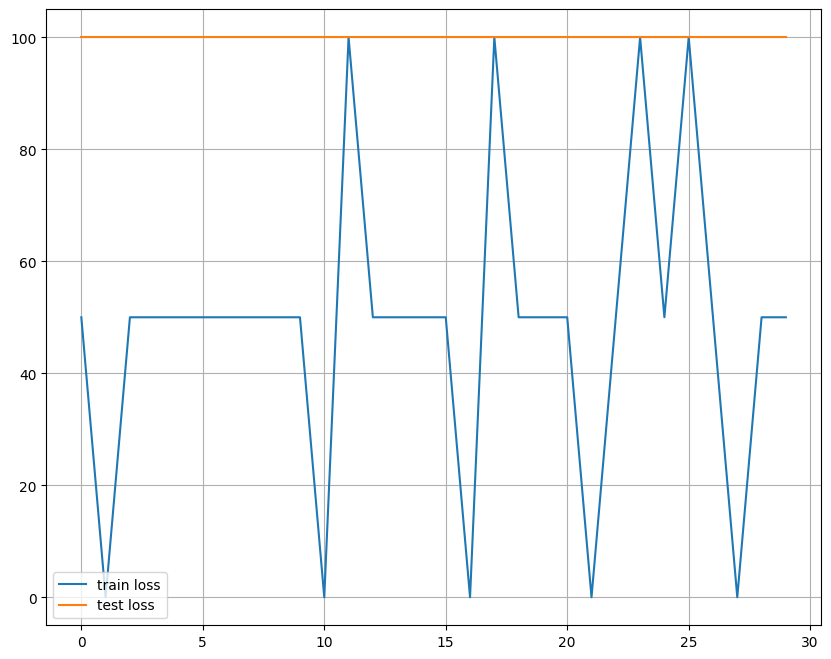

In [122]:
plt.figure(figsize=(10,8))
plt.plot(train_losses,label="train loss")
plt.plot(test_losses,label="test loss")
plt.grid()
plt.legend()

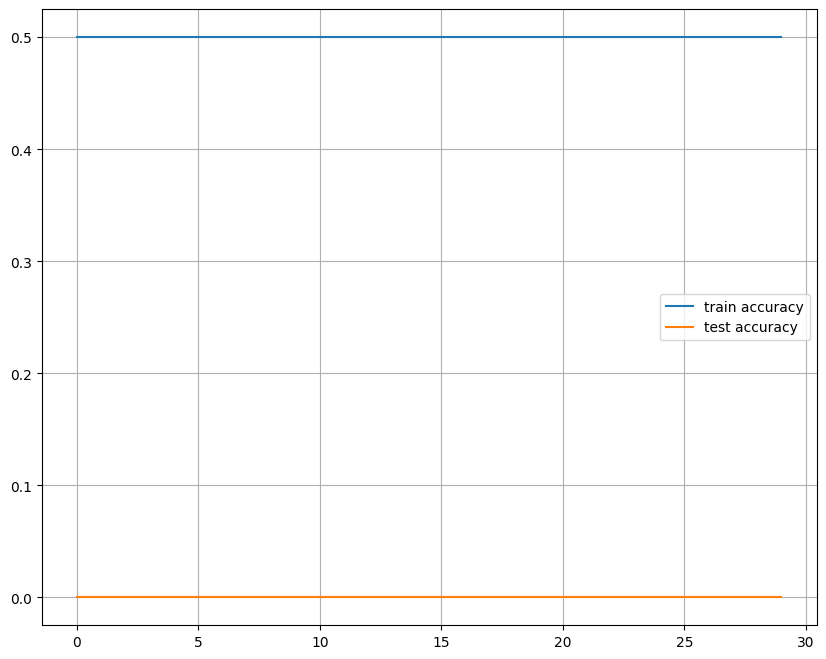

In [123]:
plt.figure(figsize=(10,8))
plt.plot(train_accs,label="train accuracy")
plt.plot(test_accs,label="test accuracy")
plt.grid()
plt.legend()

In [124]:
torch.round(pred)

tensor([[1.],
        [1.]], grad_fn=<RoundBackward0>)